# Домашнее задание ШАД МТС по теме ТВиМС 5

## Задание

Для датасета из прошлого домашнего задания необходимо:

1. Сформировать двухвыборочные гипотезы касательно медиан и распределений для дискретного и непрерывного случая. Если дискретного показателя нет - создайте его дополнительно. Итого 4 гипотезы (4 пункта).
2. Каждую гипотезу проверьте релевантным тестом и обоснуйте, почему выбрали именно его. 5-м пунктом будет проверка результатов с бутстрапом.
3. Сравните результаты из 4 пунктов с результатами бутстрапа и обоснуйте различия, если они есть. Определите какой подход мощнее в конкретном случае и почему.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm import tqdm

plt.style.use('ggplot')
%matplotlib inline

alpha = 0.05 # зададимся уровнем значимости

### Загрузка и извлечение данных из выбранного датасета

Источником данных для текущей работы будет [Adult dataset](http://www.cs.toronto.edu/~delve/data/adult/desc.html)

In [2]:
# Загружаем данные

df = pd.read_csv('./datasets/adult.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# Для удобства, создадим списки признаков

# Числовые признаки
num_cols = [
    'age',
    'fnlwgt',
    'educational-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
]

# Категориальные признаки
cat_cols = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country'
]

feature_cols = num_cols + cat_cols
target_col = 'income'

In [4]:
# Можно заметить, что некоторые значения в столбцам категориальных признаков пропущены и равны '?'. Посмотрим, сколько таких строк

df[(df[cat_cols] == '?').any(axis=1)]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
13,58,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,<=50K
19,40,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,?,>50K
22,72,?,132015,7th-8th,4,Divorced,?,Not-in-family,White,Female,0,0,6,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48811,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
48812,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
48820,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
48822,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [5]:
# Пропусков не так много, для нашей задачи их можно удалить

df.drop(df[(df[cat_cols] == '?').any(axis=1)].index, inplace=True)

***

### Формирование и проверка двухвыборочных гипотез

**Уточнение:** проверка гипотез осуществляется исключительно на данных, представленных в текущем датасете. Сделанные выводы могут не отражать общую картину генеральной совокупности

1. Влияет ли образование на уровень дохода (отличаются ли распределения уровней образования по доходам?) - дискретный - тест Пирсона (тест Хи-квадрат)
2. Однородность выборок инвестиционного дохода и инвестиционных потерь; проверяем, одинаково ли распределены инвестиционные доходы и потери среди тех, кто в принципе занимается инвестиционной деятельностью - непрерывный - критерий Колмогорова-Смирнова
3. Правда ли, что мужчины в среднем работают больше женщин (по часам в неделю)? - непрерывный - ранговый критерий Манна-Уитни
4. Правда ли, что люди, регулярно перерабатывающие, зарабатывают больше? - дискретный - точный тест Фишера.

#### Гипотеза 1

Зависит ли уровень дохода от образования? Сравним однородность распределения по уровням образования для людей с доходами >50K и <=50K

- H0: распределение по уровню образования одинаково для людей с доходами >50K и <=50K
- H1: между распределениями есть разница, образование влияет на уровень дохода

Для проверки будем использовать непараметрический Хи-квадрат критерий Пирсона, т.к. он хорошо подходит для анализа количества исходов по разным категориям.

In [6]:
df_ed_income = pd.pivot_table(df,
               index='income',
               columns='education',
               values='fnlwgt',
               aggfunc='count')
df_ed_income

education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
income,,,,,,,,,,,,,,,,
<=50K,1141,1530,534,214,427,768,638,1109,1455,4392,145,12367,1121,71,193,7909
>50K,82,89,43,8,22,55,38,398,504,3178,399,2416,1393,1,592,1990


In [7]:
# Выполним группировку по уровню образования
df_ed_income['High'] = df_ed_income['Assoc-acdm'] + df_ed_income['Assoc-voc'] + df_ed_income['Prof-school'] + \
    df_ed_income['Bachelors'] + df_ed_income['Masters'] + df_ed_income['Doctorate']
df_ed_income['Medium'] = df_ed_income['HS-grad'] + df_ed_income['Some-college']
df_ed_income['Low'] = df_ed_income['Preschool'] + df_ed_income['1st-4th'] + df_ed_income['5th-6th'] + \
    df_ed_income['7th-8th'] + df_ed_income['9th'] + df_ed_income['10th'] + df_ed_income['11th'] + df_ed_income['12th']

df_ed_income = df_ed_income[['High', 'Medium', 'Low']]
df_ed_income

education,High,Medium,Low
income,,,
<=50K,8415,20276,5323
>50K,6464,4406,338


In [8]:
pvalue = st.chi2_contingency(df_ed_income.values).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Распределение количества людей по уровням образования одинаковы для дохода >50K и <=50K')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Есть разница между распределениями, верояно уровень образования влияет на уровень дохода')

pvalue = 0.0
Отклоняем нулевую гипотезу. Есть разница между распределениями, верояно уровень образования влияет на уровень дохода


#### Гипотеза 2

Среди тех людей, которые помимо основной работы занимаются инвестиционной деятельностью, проверим однородность распределения инвестиционных доходов и инвестиционных потерь

- H0: распределения инвестиционных доходов и потерь однородны
- H1: распределения инвестиционных доходов и потерь имеют различия

Для проверки гипотезы используем двухвыборочный тест Колмогорова-Смирнова

In [9]:
df_capital_gain = df.loc[df['capital-gain'] != 0]['capital-gain']
df_capital_loss = df.loc[df['capital-loss'] != 0]['capital-loss']

pvalue = st.ks_2samp(df_capital_gain, df_capital_loss).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Инвестиционные доходы и потери распределены одинаково')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Есть разница между распределениями инвестиционных доходов и потерь')

pvalue = 0.0
Отклоняем нулевую гипотезу. Есть разница между распределениями инвестиционных доходов и потерь


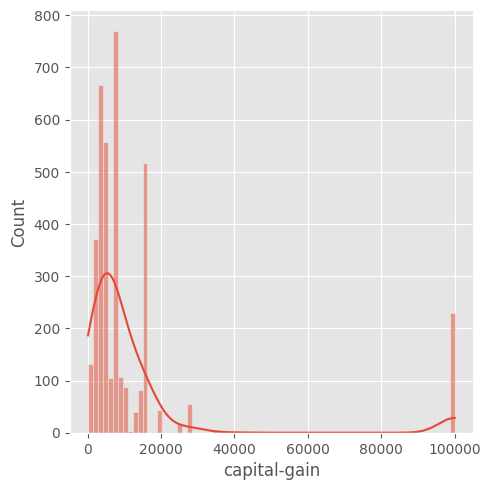

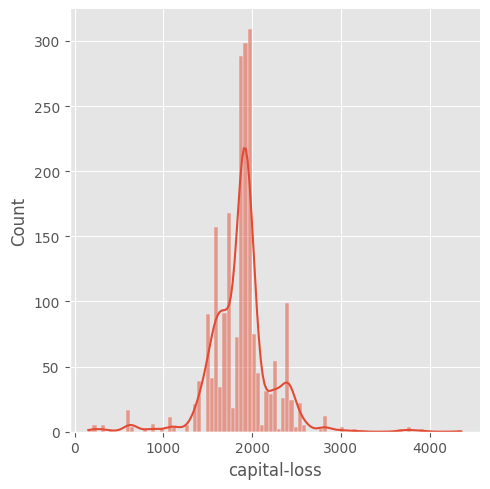

In [11]:
# провалидируем результаты визуально
sns.displot(df_capital_gain, kde=True)
sns.displot(df_capital_loss, kde=True);

#### Гипотеза 3

Правда ли то, что мужчины, в среднем, работают больше женщин?

- H0: Мужчины и женщины, в среднем, работают одинаковое количество часов
- H1: Мужчины, в среднем, работают больше женщин

Выборки имеют различное распределение, отличное от нормального. Для проверки будем использовать критерий Уилкоксона-Манна-Уитни для двух независимых выборок, а также отдельно для каждой выборки применим одновыборочный критерий Уилкоксона

In [12]:
n = 3000
df_male_hpw = df.loc[df['gender'] == 'Male']['hours-per-week'].sample(n)
df_female_hpw = df.loc[df['gender'] == 'Female']['hours-per-week'].sample(n)

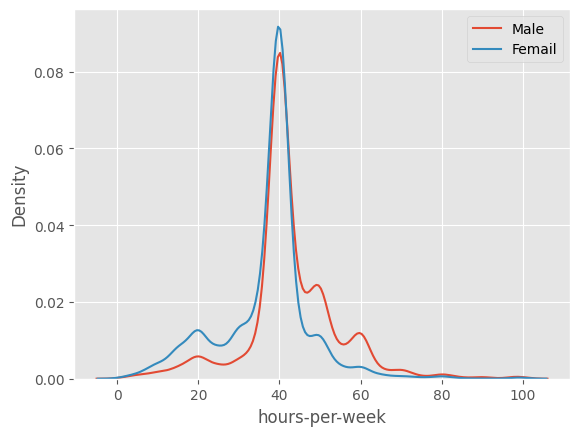

In [13]:
sns.kdeplot(df_male_hpw, label='Male')
sns.kdeplot(df_female_hpw, label='Femail')
plt.legend();

In [14]:
# выборки имеют одинаковые медианы, но различные средние из-за неоднородности распределений
df_male_hpw.mean(), df_female_hpw.mean()

(42.69266666666667, 37.022)

In [15]:
# Одновыборочный критерий ранговых знаков Уилкоксона,
# не отлоняем нулевую гипотезу при среднем значении выборки 42
st.wilcoxon(df_male_hpw - 42)

WilcoxonResult(statistic=2164567.5, pvalue=0.2762395767908902)

In [16]:
# Одновыборочный критерий ранговых знаков Уилкоксона,
# не отлоняем нулевую гипотезу при среднем значении выборки 39
st.wilcoxon(df_female_hpw - 39)

WilcoxonResult(statistic=2172113.5, pvalue=0.14268880087068272)

In [17]:
pvalue = st.mannwhitneyu(df_male_hpw, df_female_hpw, alternative='greater').pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Мужчины и женщины в среднем работают одинаковое количество часов')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Мужчины в среднем работают больше')

pvalue = 2.6396342519337848e-104
Отклоняем нулевую гипотезу. Мужчины в среднем работают больше


In [18]:
# Найдем сдвиг среднего между выборками
shift_dict = {}
for shift in np.linspace(0, 20, num=100):
    shift_dict[shift] = st.mannwhitneyu(df_male_hpw-shift, df_female_hpw, alternative='two-sided').pvalue

shift_max = list(shift_dict.keys())[np.argmax(list(shift_dict.values()))]
shift_max

3.0303030303030303

In [19]:
# Подтверждение H0 с учетом вычисленного сдвига
st.mannwhitneyu(df_male_hpw - shift_max, df_female_hpw, alternative='two-sided')

MannwhitneyuResult(statistic=4477775.0, pvalue=0.7370245893706382)

#### Гипотеза 4

Правда ли, что люди, регулярно перерабатывающие, зарабатывают больше?

- H0: Переработки не влияют на уровень зарплаты
- H1: Имеется зависимость между количеством рабочих часов и зарплатой

Для ответа на этот вопрос возьмем две выборки: с зарплатой <=50K и >50K. Для каждой выборки посчитаем количество человек, работающих <=40 часов в неделю и >40.
Сведем эти данные в таблицу сопряженности. Для анализа подобных таблиц сопряженности небольшого размера хорошо подходит точный тест Фишера.

In [20]:
x = [
    [df.loc[(df['income'] == '<=50K') & (df['hours-per-week'] <= 40)].shape[0],
     df.loc[(df['income'] == '<=50K') & (df['hours-per-week'] > 40)].shape[0]],
    [df.loc[(df['income'] == '>50K') & (df['hours-per-week'] <= 40)].shape[0],
     df.loc[(df['income'] == '>50K') & (df['hours-per-week'] > 40)].shape[0]]
]
x

[[25806, 8208], [5639, 5569]]

In [21]:
# Точный тест Фишера
pvalue = st.fisher_exact(x).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Переработки не влияют на уровень заработной платы')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Вероятно, есть некоторая зависимость')

pvalue = 0.0
Отклоняем нулевую гипотезу. Вероятно, есть некоторая зависимость


In [22]:
# Дополнително проверим тестом Хи-квадрат
pvalue = st.chi2_contingency(x).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Переработки не влияют на уровень заработной платы')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Вероятно, есть некоторая зависимость')

pvalue = 0.0
Отклоняем нулевую гипотезу. Вероятно, есть некоторая зависимость


### Сравнение полученных результатов с бутстрепом

In [23]:
def bootstrap_ci_2samp(r1, r2, type='mean', iter=1000, alpha=0.05):
    """Доверительный интервал распределения разниц выбранной метрики двух выборок"""
    r_list = []
    for i in range(iter + 1):
        r1_ = np.random.choice(r1, size=r1.shape[0], replace=True)
        r2_ = np.random.choice(r2, size=r2.shape[0], replace=True)
        if type == 'mode':
            r_list.append(sts.mode(r1_)[0] - sts.mode(r2_)[0])
        elif type == 'median':
            r_list.append(np.median(r1_) - np.median(r2_))
        elif type == 'var':
            r_list.append(np.var(r1_) - np.var(r2_))
        else:
            r_list.append(np.mean(r1_) - np.mean(r2_))
    left, right = np.percentile(r_list, q=[round(alpha*50, 1), round(100 - alpha*50, 1)])
    return left, right

#### Гипотеза 1 (бутстреп)

In [24]:
df_ed_income

education,High,Medium,Low
income,,,
<=50K,8415,20276,5323
>50K,6464,4406,338


In [25]:
left, right = bootstrap_ci_2samp(df_ed_income.values[0], df_ed_income.values[1])
print(f'Bootstrap CI: ({left}, {right})')
if (left < 0 < right):
    print('Не отклоняем H0, статистически значимых различий нет')
else:
    print('Отклоняем H0, есть статистически значимые различия')

Bootstrap CI: (575.666666666667, 14953.666666666666)
Отклоняем H0, есть статистически значимые различия


**Вывод:** результаты бутстрепа совпадают с результатами базового статистического теста

#### Гипотеза 2 (бутстреп)

In [26]:
df_capital_gain, df_capital_loss

(3         7688
 7         3103
 10        6418
 14        3103
 25        7298
          ...  
 48796     3471
 48799    99999
 48819    15020
 48829     1086
 48841    15024
 Name: capital-gain, Length: 3790, dtype: int64,
 52       1721
 82       1876
 129      2415
 143      1887
 154      1887
          ... 
 48722    1887
 48724    1602
 48726    1669
 48739    1977
 48781     880
 Name: capital-loss, Length: 2140, dtype: int64)

In [27]:
left, right = bootstrap_ci_2samp(df_capital_gain, df_capital_loss)
print(f'Bootstrap CI: ({left}, {right})')
if (left < 0 < right):
    print('Не отклоняем H0, статистически значимых различий нет')
else:
    print('Отклоняем H0, есть статистически значимые различия')

Bootstrap CI: (10513.874354548369, 11952.37044238404)
Отклоняем H0, есть статистически значимые различия


**Вывод:** результаты бутстрепа совпадают с результатами базового статистического теста

#### Гипотеза 3

In [28]:
df_male_hpw, df_female_hpw

(11154    60
 853      50
 6555     40
 43275    45
 4985     40
          ..
 42667    45
 41052    40
 22097    45
 29214    55
 42177    40
 Name: hours-per-week, Length: 3000, dtype: int64,
 33047    40
 47074    10
 38167    40
 9655     40
 38119    55
          ..
 16347    40
 15901    40
 7090     40
 19960    20
 28888    40
 Name: hours-per-week, Length: 3000, dtype: int64)

In [29]:
left, right = bootstrap_ci_2samp(df_male_hpw, df_female_hpw)
print(f'Bootstrap CI: ({left}, {right})')
if (left < 0 < right):
    print('Не отклоняем H0, статистически значимых различий нет')
else:
    print('Отклоняем H0, есть статистически значимые различия')

Bootstrap CI: (5.086999999999996, 6.2506666666666675)
Отклоняем H0, есть статистически значимые различия


**Вывод:** результаты бутстрепа совпадают с результатами базового статистического теста

#### Гипотеза 4

In [30]:
x = np.array(x)
x

array([[25806,  8208],
       [ 5639,  5569]])

In [31]:
left, right = bootstrap_ci_2samp(x[0], x[1])
print(f'Bootstrap CI: ({left}, {right})')
if (left < 0 < right):
    print('Не отклоняем H0, статистически значимых различий нет')
else:
    print('Отклоняем H0, есть статистически значимые различия')

Bootstrap CI: (2569.0, 20237.0)
Отклоняем H0, есть статистически значимые различия


**Вывод:** результаты бутстрепа совпадают с результатами базового статистического теста

### Выводы о мощности проведенных базовых статистических тестах и бутстрепа

Под мощностью теста подразумеваем вероятность принятия альтернативной гипотезы H1, когда она верна.

Во всех выполненных тестах мы отклонили H0 в пользу принятия H1, поэтому сравним количество принятия гипотез H1 для каждого вышерассмотренного кейса

#### Гипотеза 1

In [32]:
c_test = c_bootstrap = 0 # количество принятий H1
i = 1000 # количество тестов

for _ in tqdm(range(0, i)):
    if st.chi2_contingency(df_ed_income.values).pvalue < alpha:
        c_test += 1
    left, right = bootstrap_ci_2samp(df_ed_income.values[0], df_ed_income.values[1])
    if not (left < 0 < right):
        c_bootstrap += 1

100%|██████████| 1000/1000 [00:45<00:00, 22.20it/s]


In [33]:
c_test, c_bootstrap

(1000, 1000)

**Вывод:** для рассмотренного кейса мощность бутстреп и базового статистического теста примерно равны

#### Гипотеза 2

In [34]:
c_test = c_bootstrap = 0 # количество принятий H1
i = 1000 # количество тестов

for _ in tqdm(range(0, i)):
    if st.ks_2samp(df_capital_gain, df_capital_loss).pvalue < alpha:
        c_test += 1
    left, right = bootstrap_ci_2samp(df_capital_gain, df_capital_loss)
    if not (left < 0 < right):
        c_bootstrap += 1

100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


In [35]:
c_test, c_bootstrap

(1000, 1000)

**Вывод:** для рассмотренного кейса мощность бутстреп и базового статистического теста примерно равны

#### Гипотеза 3

In [36]:
c_test = c_bootstrap = 0 # количество принятий H1
i = 1000 # количество тестов

for _ in tqdm(range(0, i)):
    if st.mannwhitneyu(df_male_hpw, df_female_hpw, alternative='greater').pvalue < alpha:
        c_test += 1
    left, right = bootstrap_ci_2samp(df_male_hpw, df_female_hpw)
    if not (left < 0 < right):
        c_bootstrap += 1

100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]


In [37]:
c_test, c_bootstrap

(1000, 1000)

**Вывод:** для рассмотренного кейса мощность бутстреп и базового статистического теста примерно равны

#### Гипотеза 4

In [38]:
c_test = c_bootstrap = 0 # количество принятий H1
i = 1000 # количество тестов

for _ in tqdm(range(0, i)):
    if st.fisher_exact(x).pvalue < alpha:
        c_test += 1
    left, right = bootstrap_ci_2samp(x[0], x[1])
    if not (left < 0 < right):
        c_bootstrap += 1

100%|██████████| 1000/1000 [00:45<00:00, 21.93it/s]


In [39]:
c_test, c_bootstrap

(1000, 1000)

**Вывод:** для рассмотренного кейса мощность бутстреп и базового статистического теста примерно равны